In [1]:
!pip install -q peft accelerate


In [2]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import os

from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset

from peft import LoraConfig, get_peft_model


2026-02-06 10:47:54.942470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770374874.963832     164 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770374874.970310     164 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770374874.987249     164 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770374874.987279     164 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770374874.987282     164 computation_placer.cc:177] computation placer alr

In [3]:
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("logs", exist_ok=True)
os.makedirs("figures", exist_ok=True)

print("Device:", device)


Device: cuda


In [4]:
EPOCHS = 1
BATCH_SIZE = 4
MAX_LEN = 64
LOG_EVERY = 200
LR = 5e-5


In [5]:
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token

dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")


def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN
    )


dataset = dataset.map(tokenize, batched=True)
dataset.set_format("torch")


In [6]:
TRACK_LAYERS = [
    "transformer.h.0",
    "transformer.h.2",
    "transformer.h.4"
]


In [22]:
def train_and_log(model, run_name):

    model.train()

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=LR
    )

    grad_logs = {}
    projections = {}


    for name, param in model.named_parameters():
        if param.requires_grad:
            grad_logs[name] = []
            
            size = param.numel()

            projections[name] = torch.randn(
                size,
                device=device
            )


    global_step = 0


    for epoch in range(EPOCHS):

        print("Epoch:", epoch + 1)

        for i in range(0, len(dataset), BATCH_SIZE):

            batch = dataset[i:i + BATCH_SIZE]

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=input_ids
            )

            loss = outputs.loss
            loss.backward()


            if global_step % LOG_EVERY == 0:

                for name, param in model.named_parameters():

                    if name not in grad_logs:
                        continue

                    if param.grad is None:
                        continue

                    g = param.grad.detach().flatten()
                    p = projections[name]

                    proj = torch.dot(g, p).item()
                    norm = torch.norm(g).item()

                    grad_logs[name].append({
                        "step": global_step,
                        "norm": norm,
                        "proj": proj
                    })


            optimizer.step()
            optimizer.zero_grad()
            torch.cuda.empty_cache()

            global_step += 1


    path = f"logs/{run_name}.pt"

    torch.save(grad_logs, path)

    print("Saved:", path)

    return grad_logs


In [23]:
full_model = AutoModelForCausalLM.from_pretrained(
    "distilgpt2"
).to(device)

full_logs = train_and_log(
    full_model,
    "full_ft"
)


Epoch: 1
Saved: logs/full_ft.pt


In [24]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["c_attn", "c_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)


In [25]:
base_model = AutoModelForCausalLM.from_pretrained(
    "distilgpt2"
)

lora_model = get_peft_model(base_model, lora_config)

lora_model = lora_model.to(device)

lora_model.print_trainable_parameters()


lora_logs = train_and_log(
    lora_model,
    "lora_ft"
)


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 405,504 || all params: 82,318,080 || trainable%: 0.4926
Epoch: 1
Saved: logs/lora_ft.pt


In [26]:
full_logs = torch.load("logs/full_ft.pt")
lora_logs = torch.load("logs/lora_ft.pt")


In [27]:
def process(logs):

    out = {}

    for k, records in logs.items():

        s, n, p = [], [], []

        for r in records:
            s.append(r["step"])
            n.append(r["norm"])
            p.append(abs(r["proj"]))

        out[k] = {
            "steps": np.array(s),
            "norms": np.array(n),
            "projs": np.array(p)
        }

    return out


full_p = process(full_logs)
lora_p = process(lora_logs)


In [28]:
def aggregate_projection_variance(processed):

    all_proj = []

    for layer in processed.values():
        all_proj.extend(layer["projs"])

    return np.var(all_proj), np.mean(all_proj)


In [29]:
full_var, full_mean = aggregate_projection_variance(full_p)
lora_var, lora_mean = aggregate_projection_variance(lora_p)

print("FULL FT")
print("Projection variance:", round(full_var, 4))
print("Mean projection:", round(full_mean, 4))

print("\nLoRA")
print("Projection variance:", round(lora_var, 4))
print("Mean projection:", round(lora_mean, 4))


FULL FT
Projection variance: 4.1175
Mean projection: 0.2292

LoRA
Projection variance: 0.0152
Mean projection: 0.0887


In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt

full_logs = torch.load("logs/full_ft.pt")
lora_logs = torch.load("logs/lora_ft.pt")

print("Loaded Full FT layers:", len(full_logs))
print("Loaded LoRA layers:", len(lora_logs))


Loaded Full FT layers: 76
Loaded LoRA layers: 36


In [39]:
def extract_projections(logs):
    projs = []

    for layer in logs:
        for rec in logs[layer]:
            projs.append(abs(rec["proj"]))

    return np.array(projs)


full_proj = extract_projections(full_logs)
lora_proj = extract_projections(lora_logs)

print("Full FT samples:", len(full_proj))
print("LoRA samples:", len(lora_proj))


Full FT samples: 3496
LoRA samples: 1656


In [40]:
def clip_outliers(x, q=0.99):
    return x[x < np.quantile(x, q)]

full_proj_c = clip_outliers(full_proj)
lora_proj_c = clip_outliers(lora_proj)


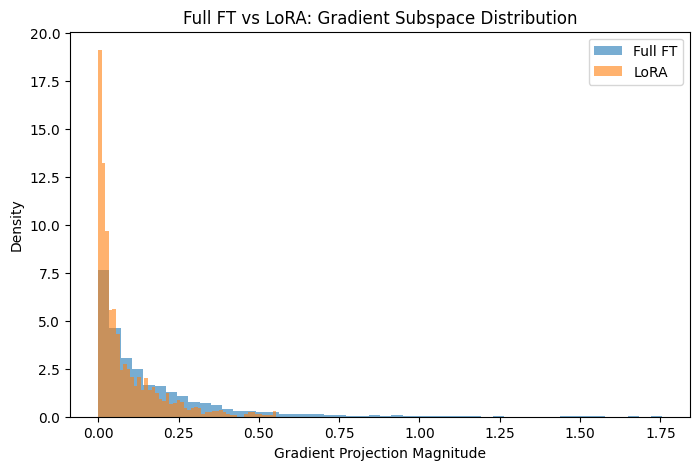

In [45]:
plt.figure(figsize=(8,5))

plt.hist(
    full_proj_c,
    bins=50,
    density=True,
    alpha=0.6,
    label="Full FT"
)

plt.hist(
    lora_proj_c,
    bins=50,
    density=True,
    alpha=0.6,
    label="LoRA"
)

plt.xlabel("Gradient Projection Magnitude")
plt.ylabel("Density")
plt.title("Full FT vs LoRA: Gradient Subspace Distribution")
plt.legend()
plt.show()


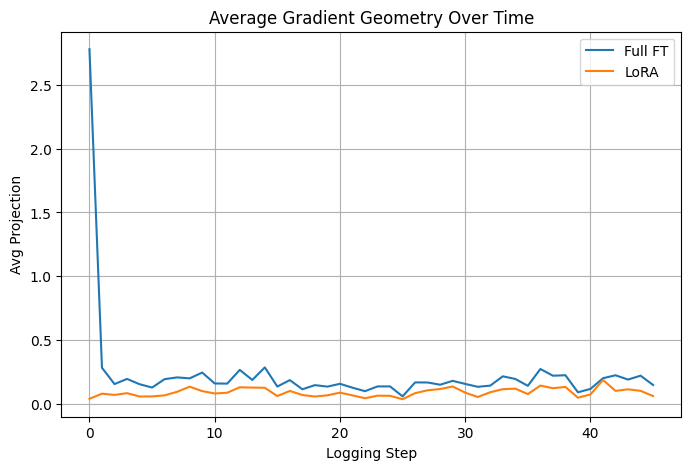

In [32]:
def avg_over_time(processed):

    max_len = min(len(v["projs"]) for v in processed.values())

    arr = []

    for layer in processed.values():
        arr.append(layer["projs"][:max_len])

    return np.mean(np.stack(arr), axis=0)


full_avg = avg_over_time(full_p)
lora_avg = avg_over_time(lora_p)


steps = np.arange(len(full_avg))


plt.figure(figsize=(8,5))

plt.plot(steps, full_avg, label="Full FT")
plt.plot(steps, lora_avg, label="LoRA")

plt.xlabel("Logging Step")
plt.ylabel("Avg Projection")
plt.title("Average Gradient Geometry Over Time")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_164/4233197925.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


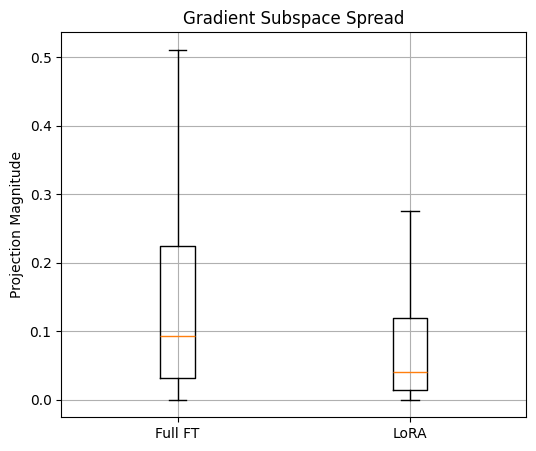

In [33]:
plt.figure(figsize=(6,5))

plt.boxplot(
    [full_vals, lora_vals],
    labels=["Full FT", "LoRA"],
    showfliers=False
)

plt.ylabel("Projection Magnitude")
plt.title("Gradient Subspace Spread")
plt.grid(True)
plt.show()


In [42]:
print("Full FT")
print("Mean:", np.mean(full_proj))
print("Std :", np.std(full_proj))

print("\nLoRA")
print("Mean:", np.mean(lora_proj))
print("Std :", np.std(lora_proj))


Full FT
Mean: 0.22923886705645083
Std : 2.0291654325380595

LoRA
Mean: 0.08866385731535091
Std : 0.12345759836818514
